# Label-free classification using SCIP features

## Package imports

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
from scip_workflows.common import *

In [26]:
import fcsparser
from scip_workflows import core
import flowutils
import shap
shap.initjs()

In [27]:
import sklearn.base
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize, scale, minmax_scale, LabelEncoder, StandardScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn import tree
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold

In [28]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from imblearn.pipeline import make_pipeline as imb_make_pipeline

In [29]:
from multiprocessing import Pool
from scipy.stats import spearmanr
import pickle
import hiplot

In [30]:
plt.rcParams['figure.dpi'] = 200

## Data import

In [57]:
try:
    features = snakemake.input.features
    index = snakemake.input.index
    columns = snakemake.input.columns
    labels = snakemake.input.labels
    hpo_full = snakemake.input.hpo_full
    hpo_cyto = snakemake.input.hpo_cyto
    output_confmat_full = snakemake.output.confmat_full
    output_confmat_cyto = snakemake.output.confmat_cyto
    output_metrics_full = snakemake.output.metrics_full
    output_metrics_cyto = snakemake.output.metrics_cyto
except NameError:
    data_root = Path("/home/maximl/scratch/data/vsc/datasets/wbc/")
    # data_root = Path(os.environ["VSC_DATA_VO_USER"]) / "datasets/wbc"
    data_scip = data_root / "scip/20220713131400/"
    features = data_scip / "WBC_features.parquet"
    index = data_scip / "indices/index.npy"
    columns = data_scip / "indices/columns.npy"
    labels = data_scip / "labels.parquet"
    hpo_full = data_scip / "hpo" / "WBC_rsh_scip_full_li_xgboost.pickle"
    hpo_cyto = data_scip / "hpo" / "WBC_rsh_scip_cyto_li_xgboost.pickle"
    output_confmat_full = data_scip / "figures" / "WBC_scip_full_cv_confmat.png"
    output_confmat_cyto = data_scip / "figures" / "WBC_scip_cyto_cv_confmat.png"
    output_metrics_full = data_scip / "figures" / "WBC_scip_full_cv_metrics.png"
    output_metrics_cyto = data_scip / "figures" / "WBC_scip_cyto_cv_metrics.png"

In [33]:
df_scip = pq.read_table(features).to_pandas()

df_scip = df_scip[numpy.load(columns, allow_pickle=True)]
df_scip = df_scip.loc[numpy.load(index, allow_pickle=True)]

labels = pq.read_table(labels).to_pandas()
df_scip = df_scip.merge(labels, left_index=True, right_index=True)
# df_scip["meta_label"] = pandas.Categorical(df_scip["meta_label"], ordered=True)

df_scip.shape

(218404, 3923)

In [34]:
df_scip["meta_label"].value_counts()

CD15 + Neutrophils    132536
CD4 T cells            32183
CD8 T cell             13899
unknown                13248
CD19 pos B cells        8408
CD56+ NK Cells          6207
NK T cells              4231
CD14+ Monocyte          4041
Eosinophils             3651
Name: meta_label, dtype: int64

In [35]:
df = df_scip

In [36]:
df.shape

(218404, 3923)

## Continue with events assigned to cell states

I filter out the events falling between manual gates. This is only a small amount of events

In [37]:
df = df.loc[df["meta_label"] != "unknown"].copy()
df.shape

(205156, 3923)

In [38]:
df["meta_label"] = df["meta_label"].astype("category")

In [39]:
enc = LabelEncoder().fit(df["meta_label"])

## Classification and feature analysis using an Extreme Gradient Boosting classifier

### Tuning hyper parameters

We inspect the results from recursive successive halving hyper parameter optimization

In [40]:
def rsh_plot(grid):
    results = pandas.DataFrame(grid.cv_results_)
    results["params_str"] = results.params.apply(lambda foo: str({k:v for k,v in foo.items() if k != "xgbclassifier__n_estimators"}))
    
    results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
    mean_scores = results.pivot(
        index="iter", columns="params_str", values="mean_test_score"
    )
    
    fig, ax = plt.subplots(dpi=150)
    
    twin_res = ax.twinx()
    twin_cand = ax.twinx()
    twin_cand.spines.right.set_position(("axes", 1.2))
    
    p1, = twin_res.plot(
        numpy.arange(grid.n_iterations_), 
        [grid.n_resources_[i] for i in range(grid.n_iterations_)], 
        "--", alpha=0.7, linewidth=1, color="#E09F3E", zorder=-1)
    p2, = twin_cand.plot(
        numpy.arange(grid.n_iterations_), 
        [grid.n_candidates_[i] for i in range(grid.n_iterations_)], 
        "--", alpha=0.7, linewidth=1, color="#004E98", zorder=-2)
    
    mean_scores.plot(legend=False, alpha=0.6, ax=ax, color="#E15554", zorder=2)
    
    twin_res.yaxis.label.set_color(p1.get_color())
    twin_cand.yaxis.label.set_color(p2.get_color())

    ax.set_xticks(range(grid.n_iterations_))
    ax.set_title("Scores of candidates over iterations")
    ax.set_ylabel("balanced accuracy", fontsize=10)
    ax.set_xlabel("iterations", fontsize=10)
    twin_res.set_ylabel("Number of resources")
    twin_cand.set_ylabel("Number of candidates")
    twin_res.tick_params(axis='y', colors=p1.get_color())
    twin_cand.tick_params(axis='y', colors=p2.get_color())
    
    seaborn.despine(fig, right=False, trim=True)
    
def hip_plot(grid):
    df = pandas.DataFrame(grid.cv_results_["params"])
    df["mean_test_balanced_accuracy"] = grid.cv_results_["mean_test_score"]
    df["mean_train_balanced_accuracy"] = grid.cv_results_["mean_train_score"]
    df["std_test_balanced_accuracy"] = grid.cv_results_["std_test_score"]
    df["std_train_balanced_accuracy"] = grid.cv_results_["std_train_score"]

    hiplot.Experiment.from_iterable(df.to_dict(orient="records")).display()

In [41]:
with open(hpo_full, "rb") as fh:
    grid_full = pickle.load(fh)

Trying to unpickle estimator HalvingRandomSearchCV from version 1.1.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


In [42]:
tested_values = {"xgbclassifier__max_depth": [6, 5, 4, 3, 2],
        "xgbclassifier__learning_rate": [0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.01, 0.001],
        "xgbclassifier__subsample": numpy.arange(start=0.1, stop=1.1, step=.1),
        "xgbclassifier__colsample_bytree": numpy.arange(start=0.1, stop=1.1, step=.1),
        "xgbclassifier__gamma": numpy.arange(start=0, stop=31, step=2),
        "xgbclassifier__min_child_weight": numpy.arange(start=1, stop=32, step=2),
        "xgbclassifier__n_estimators": numpy.arange(start=10, stop=301, step=10)
}

In [43]:
pandas.set_option('display.max_colwidth',1000)

In [44]:
tmp_df = pandas.DataFrame([e.best_params_ for e in grid_full["estimator"]]).T
for k,v in tested_values.items():
    if type(v[0]) is numpy.float64:
        tmp_df.loc[k, "tested values"] = ", ".join(["%.2f" % i for i in v])
    else:
        tmp_df.loc[k, "tested values"] = ", ".join([str(i) for i in v])
tmp_df.index = [c[len("xgbclassifier__"):] for c in tmp_df.index]
print(tmp_df.to_latex(float_format="%.2f", escape=False))

\begin{tabular}{lrrrrrl}
\toprule
{} &      0 &      1 &      2 &      3 &      4 &                                                                                                                                tested values \\
\midrule
subsample        &   0.10 &   0.10 &   0.10 &   0.50 &   0.50 &                                                                                   0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00 \\
n_estimators     & 290.00 & 260.00 & 260.00 & 270.00 & 270.00 &  10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300 \\
min_child_weight &  11.00 &  19.00 &  19.00 &  19.00 &  19.00 &                                                                                    1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31 \\
max_depth        &   3.00 &   4.00 &   4.00 &   6.00 &   6.00 &                                                                            

In [45]:
grid_full["test_balanced_accuracy"].mean(), scipy.stats.sem(grid_full["test_balanced_accuracy"])

(0.7691934707721455, 0.004302335376836568)

In [46]:
grid_full["test_balanced_accuracy"], grid_full["train_balanced_accuracy"]

(array([0.75838555, 0.76129523, 0.76842004, 0.77834882, 0.77951771]),
 array([0.80508451, 0.83211546, 0.82925101, 0.86815152, 0.86871643]))

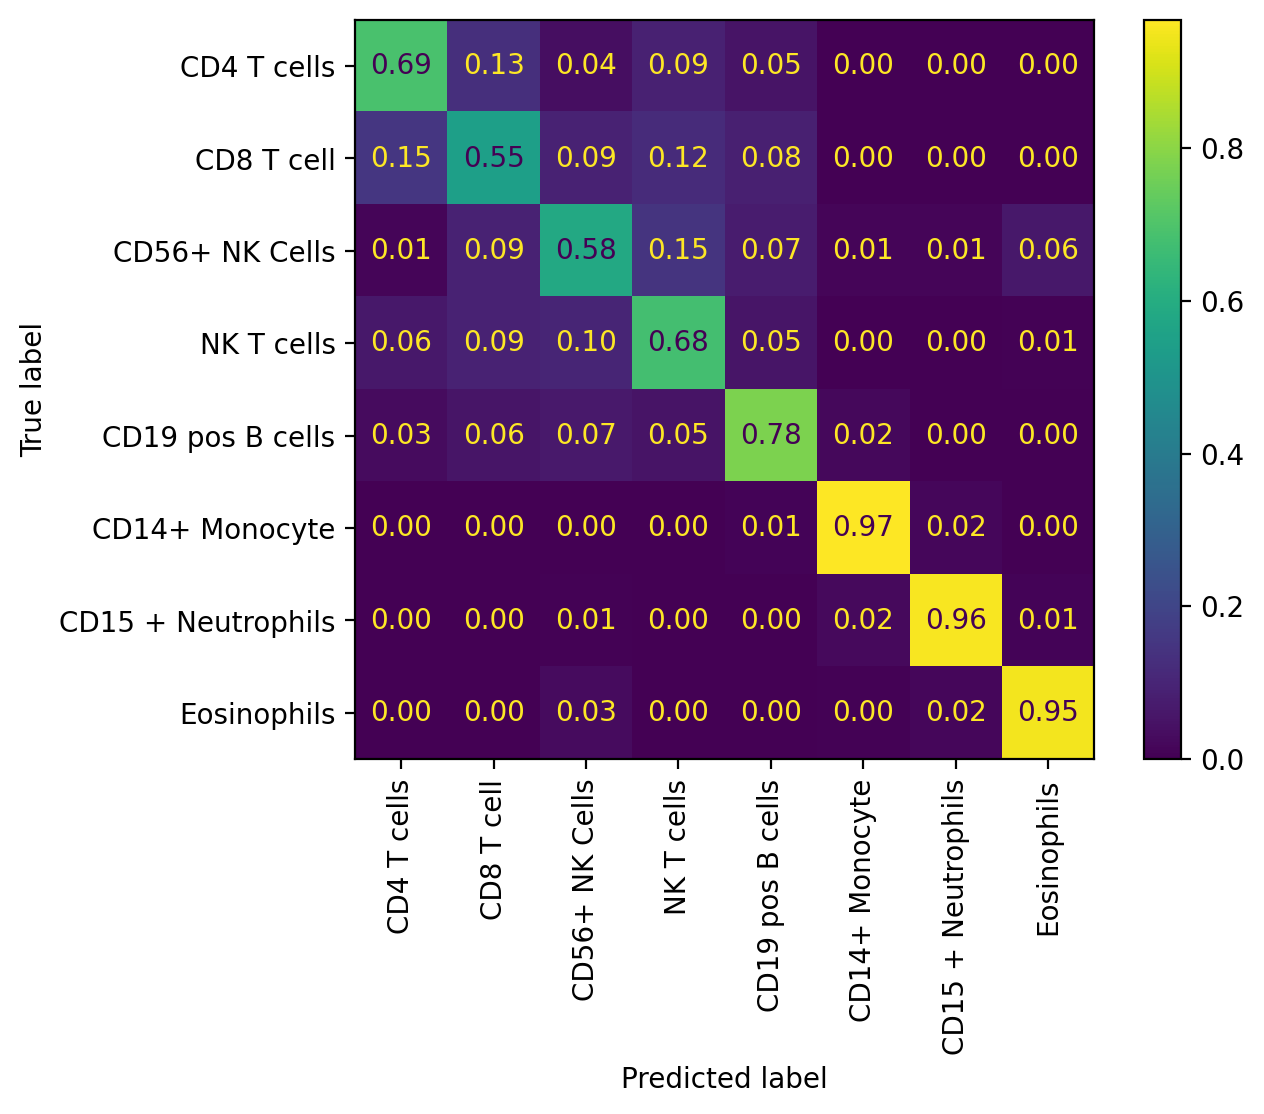

In [58]:
X = df.filter(regex="(BF1|BF2|SSC)$")
y = enc.transform(df["meta_label"])
preds = []
true = []

skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
for estimator, (_, test_index) in zip(grid_full["estimator"], skf.split(X, y)):
    X_test, y_test = X.iloc[test_index], y[test_index]
    preds.extend(estimator.predict(X_test))    
    true.extend(y_test)

fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(
    true, preds, 
    labels=[3, 5, 4, 7, 2, 0, 1, 6],
    display_labels=enc.classes_[[3, 5, 4, 7, 2, 0, 1, 6]],
    normalize='true', xticks_rotation="vertical", values_format=".2f",
    ax=ax
)
plt.savefig(output_confmat_full, bbox_inches="tight")

<AxesSubplot:xlabel='value', ylabel='metric'>

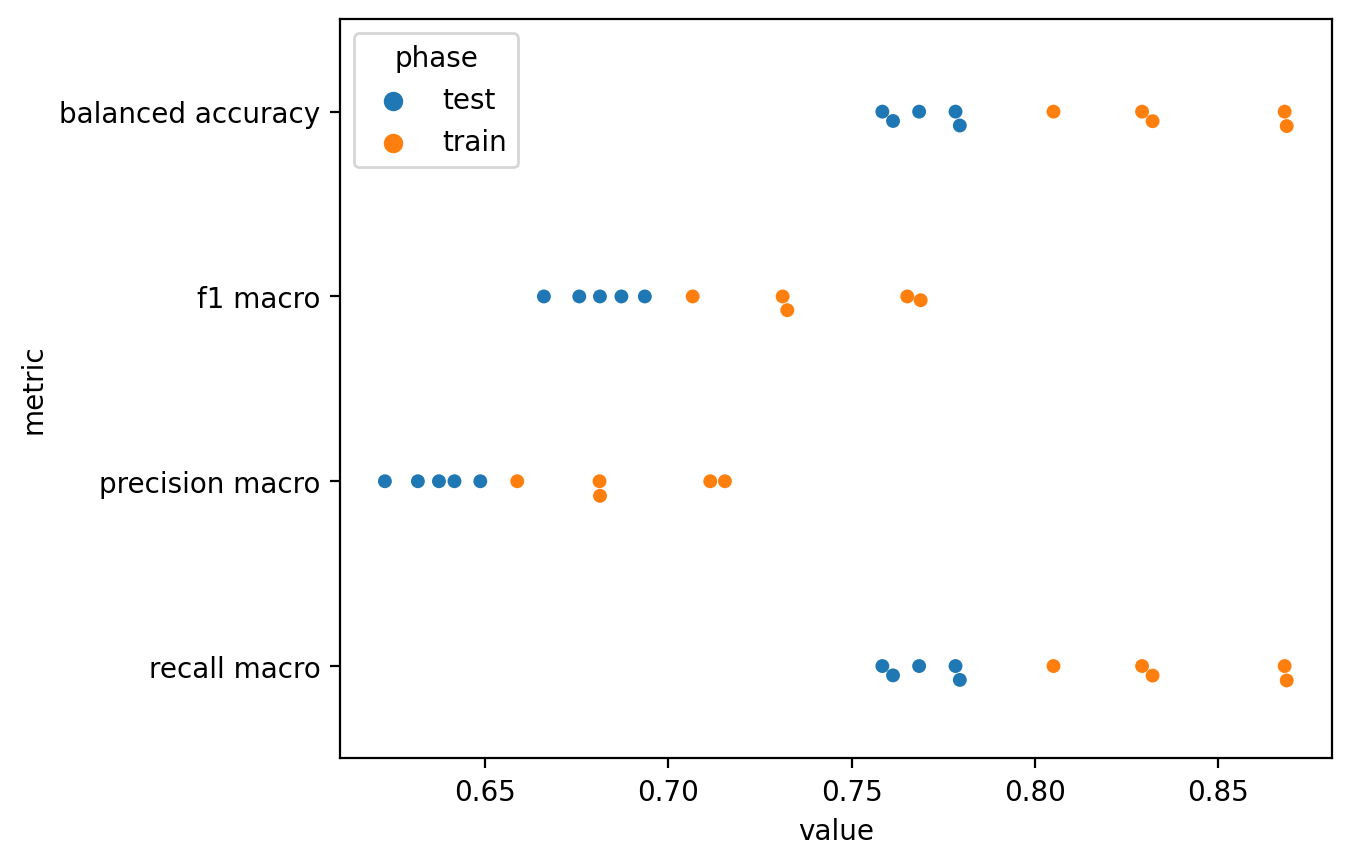

In [25]:
grid_full_df = pandas.DataFrame(grid_full).drop(columns=["score_time", "fit_time", "estimator"]).melt()
grid_full_df["phase"] = grid_full_df["variable"].apply(lambda r: r.split("_")[0])
grid_full_df["metric"] = grid_full_df["variable"].apply(lambda r: " ".join(r.split("_")[1:]))

seaborn.swarmplot(data=grid_full_df, x='value', y='metric', hue='phase')

plt.savefig(output_metrics_full, bbox_inches="tight")

In [65]:
scores_df = grid_full_df.groupby(["metric", "phase"])["value"].agg(['mean', scipy.stats.sem])
scores_df.index.names = ["Metric", "Phase"]
scores_df["Mean (std. error)"] = scores_df.apply(lambda r: "%.3f (%.3f)" % (r["mean"], r["sem"]), axis=1)
scores_df = scores_df.reset_index().pivot(index="Metric", values="Mean (std. error)", columns="Phase")
scores_df.index.name = ""

print(scores_df.style.to_latex(hrules=True))

\begin{tabular}{lll}
\toprule
Phase & test & train \\
 &  &  \\
\midrule
balanced accuracy & 0.769 (0.004) & 0.841 (0.012) \\
f1 macro & 0.681 (0.005) & 0.741 (0.012) \\
precision macro & 0.636 (0.004) & 0.690 (0.011) \\
recall macro & 0.769 (0.004) & 0.841 (0.012) \\
\bottomrule
\end{tabular}



In [51]:
with open(hpo_cyto, "rb") as fh:
    grid_cyto = pickle.load(fh)

Trying to unpickle estimator HalvingRandomSearchCV from version 1.1.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


In [52]:
grid_cyto["test_balanced_accuracy"].mean(), scipy.stats.sem(grid_cyto["test_balanced_accuracy"])

(0.8272259869383227, 0.002370453476150684)

In [53]:
grid_cyto["test_balanced_accuracy"], grid_cyto["train_balanced_accuracy"]

(array([0.81982083, 0.83174006, 0.82342481, 0.83097569, 0.83016854]),
 array([0.91079562, 0.9348605 , 0.94100039, 0.89823381, 0.9499213 ]))

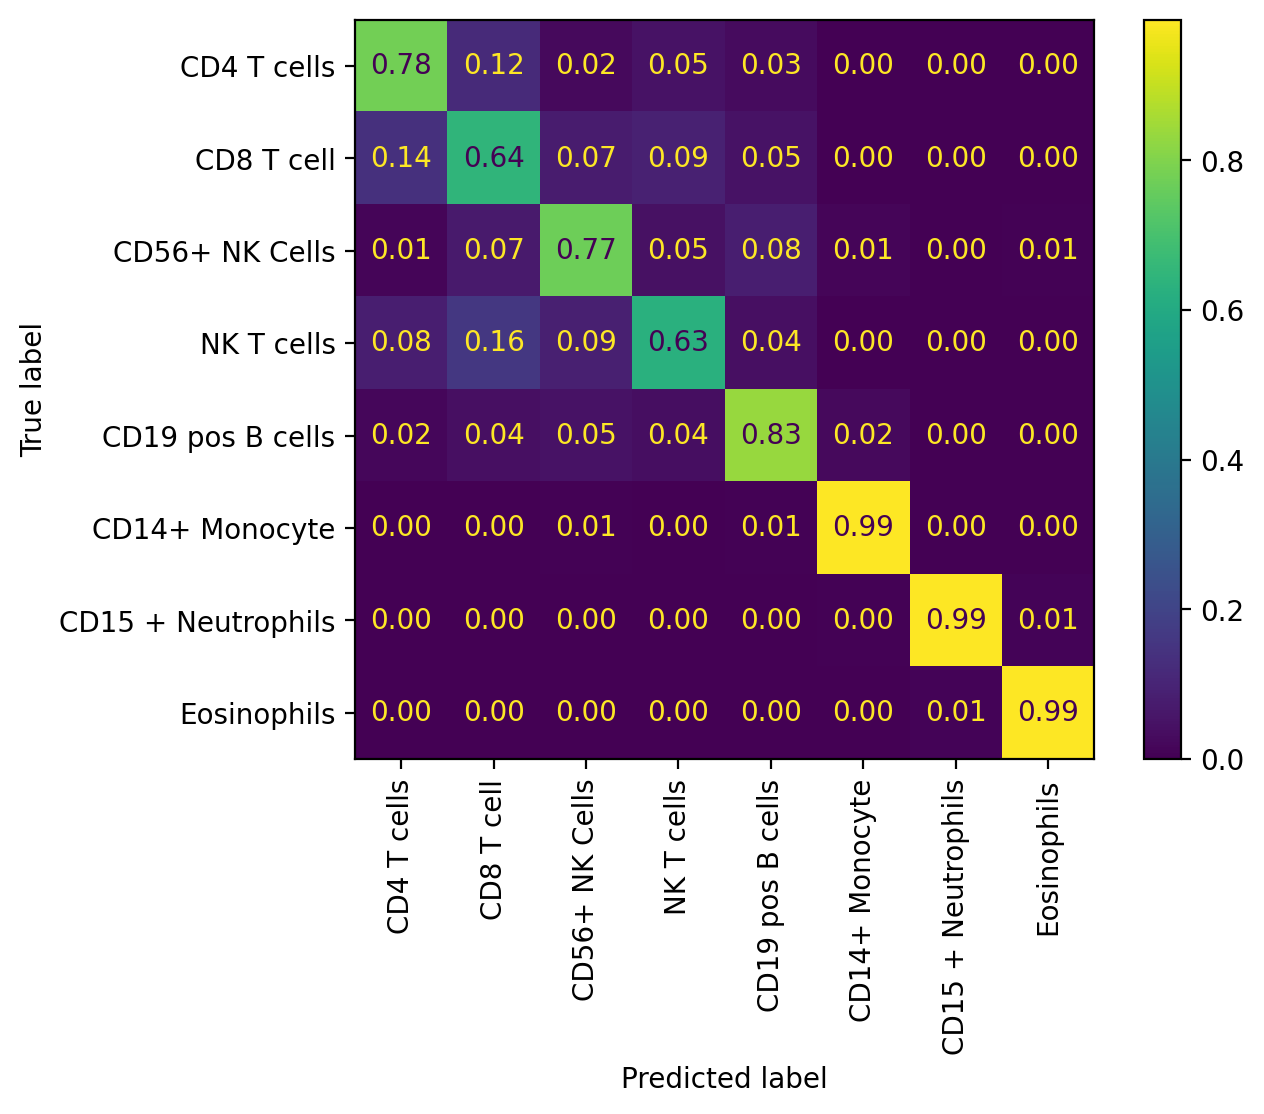

In [59]:
X = df.drop('late', level="meta_fix").drop(0, level="meta_group").filter(regex="(BF1|BF2|SSC)$")#.fillna(0)
y = enc.transform(df.drop('late', level="meta_fix").drop(0, level="meta_group")["meta_label"])
preds = []
true = []

skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
for estimator, (_, test_index) in zip(grid_cyto["estimator"], skf.split(X, y)):
    X_test, y_test = X.iloc[test_index], y[test_index]
    preds.extend(estimator.predict(X_test))    
    true.extend(y_test)

fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(
    true, preds, 
    labels=[3, 5, 4, 7, 2, 0, 1, 6],
    display_labels=enc.classes_[[3, 5, 4, 7, 2, 0, 1, 6]],
    normalize='true', xticks_rotation="vertical", values_format=".2f",
    ax=ax
)
plt.savefig(output_confmat_cyto, bbox_inches="tight")

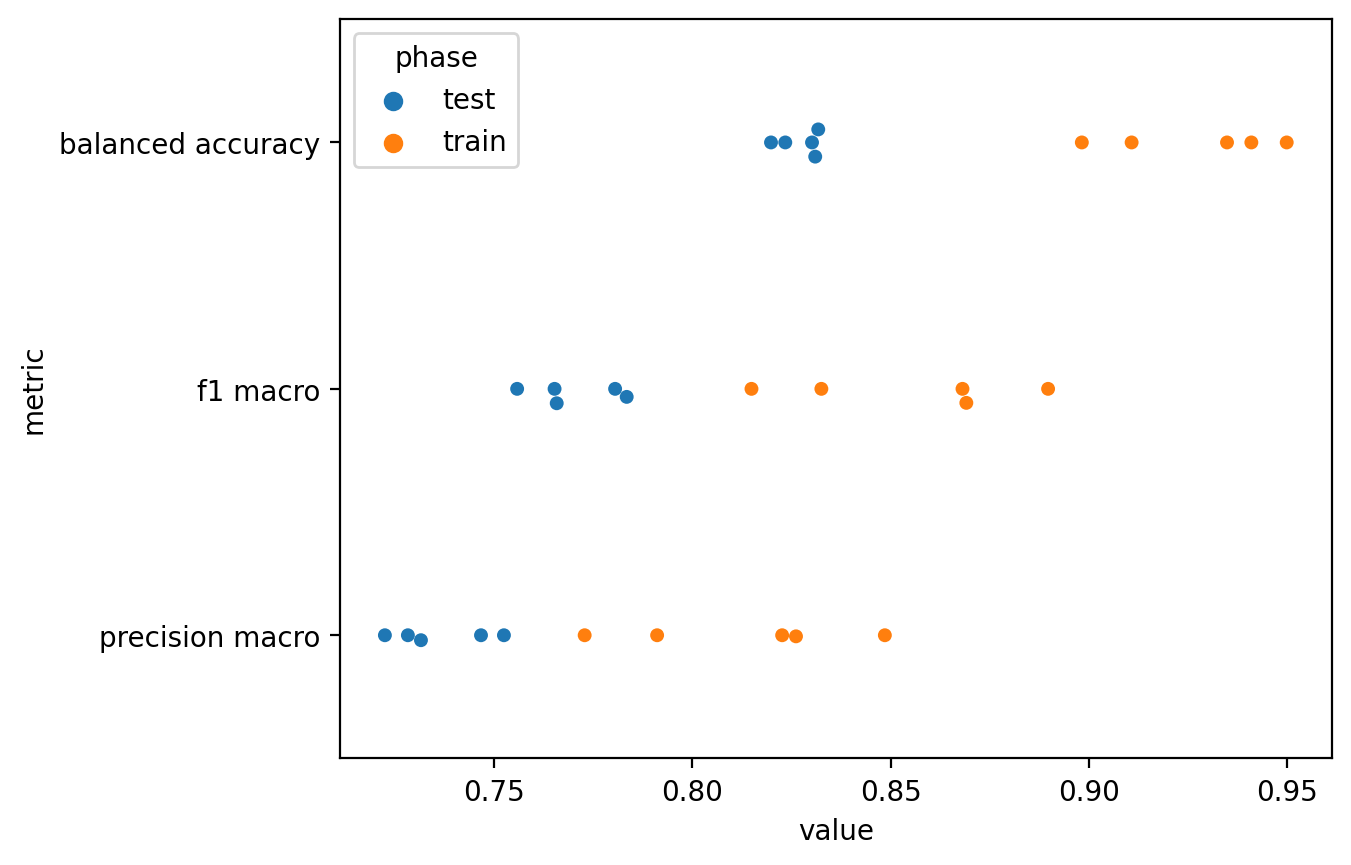

In [55]:
grid_cyto_df = pandas.DataFrame(grid_cyto).drop(columns=["score_time", "fit_time", "estimator", "train_recall_macro", "test_recall_macro"]).melt()
grid_cyto_df["phase"] = grid_cyto_df["variable"].apply(lambda r: r.split("_")[0])
grid_cyto_df["metric"] = grid_cyto_df["variable"].apply(lambda r: " ".join(r.split("_")[1:]))

seaborn.swarmplot(data=grid_cyto_df, x='value', y='metric', hue='phase')

plt.savefig(output_metrics_cyto, bbox_inches="tight")

In [56]:
scores_df = grid_cyto_df.groupby(["metric", "phase"])["value"].agg(['mean', scipy.stats.sem])
scores_df.index.names = ["Metric", "Phase"]
scores_df["Mean (std. error)"] = scores_df.apply(lambda r: "%.3f (%.3f)" % (r["mean"], r["sem"]), axis=1)
print(scores_df.reset_index().pivot(index="Metric", values="Mean (std. error)", columns="Phase").style.to_latex(hrules=True))

\begin{tabular}{lll}
\toprule
{Phase} & {test} & {train} \\
{Metric} & {} & {} \\
\midrule
balanced accuracy & 0.827 (0.002) & 0.927 (0.010) \\
f1 macro & 0.770 (0.005) & 0.855 (0.014) \\
precision macro & 0.736 (0.006) & 0.812 (0.013) \\
\bottomrule
\end{tabular}

